## Import Library

In [ ]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/Users/timothyray/miniforge3/envs/tensorflow_silicon/bin/python
3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)


In [1]:
import pandas as pd
import numpy as np
import nltk, re, string
import matplotlib.pyplot as plt
import seaborn as sns
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import joblib

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## Load the Data

In [2]:
raw_data = pd.read_excel('dataset.xlsx')  
raw_data

,title,label
0,[BENAR] Bahaya Daging Kurban Dibungkus Kresek ...,0
1,[BENAR] SPP SMA/SMK GRATIS JAWA TIMUR,0
2,"[BENAR] Dianggap Lecehkan Guru, Iklan Hago Dip...",0
3,[BENAR] Permen Jeli yang Dibuat dengan Gelatin...,0
4,[BENAR] Unggahan Hasil C1 Pleno TPS di Bangil ...,0
...,...,...
1435,"""AA Gym : Lebih baik pilih pemimpin koruptor t...",1
1436,"""Sebuah gambar dengan keterangan “Sultan Erdog...",1
1437,"""Restoran Padang ""Sederhana"" sedang merayakan ...",1
1438,"""Ini adalah binatang yang langka dan sangat be...",1


## Preprocessing

### Drop Duplicatte

In [3]:
clean_df = raw_data[raw_data['title'].duplicated()==False]
clean_df.reset_index(inplace=True)
clean_df

,index,title,label
0,0,[BENAR] Bahaya Daging Kurban Dibungkus Kresek ...,0
1,1,[BENAR] SPP SMA/SMK GRATIS JAWA TIMUR,0
2,2,"[BENAR] Dianggap Lecehkan Guru, Iklan Hago Dip...",0
3,3,[BENAR] Permen Jeli yang Dibuat dengan Gelatin...,0
4,4,[BENAR] Unggahan Hasil C1 Pleno TPS di Bangil ...,0
...,...,...,...
1416,1426,"""Pasukan Amerika Serikat sempat menyita dokume...",1
1417,1427,"""Game Pokemon Go yang marak di beberapa negara...",1
1418,1428,"""Teman2 sebaiknya bsk jgn kmna2 dulu, ada kaba...",1
1419,1431,“Dik Joko Widodo masih kuliah aja. Sy sudah ba...,1


In [4]:
news = clean_df['title'].to_numpy(dtype='str')
news

array(['[BENAR] Bahaya Daging Kurban Dibungkus Kresek Hitam',
       '[BENAR] SPP SMA/SMK GRATIS JAWA TIMUR',
       '[BENAR] Dianggap Lecehkan Guru, Iklan Hago Diprotes', ...,
       '"Teman2 sebaiknya bsk jgn kmna2 dulu, ada kabar akan ada demo karena tdk terima atas kemenangan ini. Bnyk polisi yg sdh siaga malam ini. Mohon untuk teman2 sebaiknya di rmh dulu, Info A1 dari bbrp teman di BIN, Densus dan Intel bbrp Kodam…di bbrp daerah Jabar, Jakarta dan terutama Solo…tercium plot akan ada pergerakan massa mirip 98…yg memprovokasi justru dari bbrp oknum grup 2 Kopassus yg loyal thd Prabowo…mohon waspada…Panglima dan Kapolri sdh tahu info Intelijen ini…makanya Kapolri sdh memberikan perintah tembak ditempat"',
       '“Dik Joko Widodo masih kuliah aja. Sy sudah bangun tol bersama Hutama Karya. Jd klo sekarang nerusin tol yg ada itu hanya penambahan. Jangan merasa bpk pembangunan dik jokowi. Krna bapak pembnguann masih melekat dihati rakyat adalah almarhum HM SOEHARTO Bkn yg lain. Ayo ber

In [5]:
## Ini run sekali aja, buat pertama kali, kalo udh mah comment aja
## nltk.download('stopwords')
##nltk.download('punkt')

In [6]:
#stopwords
stopwords = set(nltk.corpus.stopwords.words('indonesian'))
# slang words
slang = pd.read_csv('slang.csv')
slang_list = slang.to_numpy(dtype='str')

In [7]:
def unslang_word(word):
    if word not in slang_list[:,0]:
        return [word]
    
    index = slang_list[:,0].tolist().index(word)
    new_word = slang_list[index,1]
    
    return [w for w in new_word.split()]

In [8]:
word_dict = {}
processed_news = []

for a_news in news:
    # lemmatizer
    stemmer = StemmerFactory().create_stemmer()
    lemmatized_sentence = stemmer.stem(a_news)
    
    # sentence segmentation
    sentences = nltk.tokenize.sent_tokenize(lemmatized_sentence)
    new_words = []
    
    for sentence in sentences:
        
        # punctuations and numbers to be removed, '@' to identify mentioned user, '-' to identify sentiment word
        remove = string.punctuation.replace('-','')+'"'+'0123456789'
        # replace word, remove non ASCII, remove punctuation, remove number, remove whitespaces, to lower
        folded = sentence.replace('&amp','&').replace('&', 'dan').replace('[BENAR]','').replace('[HOAX]','').replace('(HOAX)','').replace('-',' ').replace('\n',' ').encode('ascii','ignore').decode('ascii').translate(str.maketrans('','',remove)).strip().lower()
        # word tokenizing
        words = nltk.word_tokenize(folded)
        
        for word in words:
            for new_word in unslang_word(word):

                    # stopword removal
                    if new_word in stopwords:
                        continue

                    # add processed word
                    new_words.append(new_word)
                    if new_word in word_dict.keys():
                        word_dict[new_word] += 1
                    else:
                        word_dict[new_word] = 1
    
    processed_news.append(new_words)

processed_news

[['bahaya', 'daging', 'kurban', 'bungkus', 'kresek', 'hitam'],
 ['spp', 'sekolah', 'menengah', 'kejuruan', 'gratis', 'jawa', 'timur'],
 ['anggap', 'leceh', 'guru', 'iklan', 'hago', 'protes'],
 ['permen', 'jeli', 'gelatin', 'kulit', 'tulang', 'hewan'],
 ['unggah',
  'hasil',
  'c',
  'pleno',
  'pemungutan',
  'suara',
  'bangil',
  'pasuruan',
  'beda',
  'hasil',
  'situng',
  'komisi',
  'pemelihan'],
 ['tuding',
  'tawar',
  'kerja',
  'retas',
  'situs',
  'komisi',
  'pemelihan',
  'kepolisian',
  'republik',
  'indonesia',
  'bantah'],
 ['cokelat', 'mermaid', 'makan', 'korban'],
 ['foto', 'prabowo', 'titiek', 'soeharto'],
 ['video', 'tugas', 'kpps', 'coblos', 'kertas', 'suara', 'halmahera', 'edar'],
 ['imigrasi',
  'kota',
  'semarang',
  'tangkap',
  'warga',
  'negara',
  'asing',
  'laku',
  'jahat'],
 ['komisioner',
  'komisi',
  'pemelihan',
  'ilham',
  'saputra',
  'adik',
  'kandung',
  'yuga',
  'aden',
  'tim',
  'komunikasi',
  'badan',
  'menang',
  'nasional',
  'bpn

## Bag of Words

In [9]:
word_dict

{'bahaya': 45,
 'daging': 14,
 'kurban': 3,
 'bungkus': 4,
 'kresek': 3,
 'hitam': 13,
 'spp': 1,
 'sekolah': 43,
 'menengah': 11,
 'kejuruan': 7,
 'gratis': 19,
 'jawa': 106,
 'timur': 70,
 'anggap': 31,
 'leceh': 11,
 'guru': 54,
 'iklan': 20,
 'hago': 15,
 'protes': 15,
 'permen': 44,
 'jeli': 2,
 'gelatin': 2,
 'kulit': 7,
 'tulang': 7,
 'hewan': 9,
 'unggah': 18,
 'hasil': 99,
 'c': 7,
 'pleno': 2,
 'pemungutan': 8,
 'suara': 81,
 'bangil': 1,
 'pasuruan': 4,
 'beda': 22,
 'situng': 8,
 'komisi': 88,
 'pemelihan': 42,
 'tuding': 22,
 'tawar': 14,
 'kerja': 57,
 'retas': 4,
 'situs': 17,
 'kepolisian': 106,
 'republik': 104,
 'indonesia': 535,
 'bantah': 72,
 'cokelat': 2,
 'mermaid': 1,
 'makan': 93,
 'korban': 111,
 'foto': 83,
 'prabowo': 53,
 'titiek': 1,
 'soeharto': 3,
 'video': 102,
 'tugas': 49,
 'kpps': 3,
 'coblos': 11,
 'kertas': 6,
 'halmahera': 3,
 'edar': 56,
 'imigrasi': 3,
 'kota': 113,
 'semarang': 20,
 'tangkap': 64,
 'warga': 128,
 'negara': 149,
 'asing': 25,
 '

In [10]:
max(word_dict.values())

633

In [11]:
value = {i for i in word_dict if word_dict[i]==122}
print("key by value:",value)

key by value: set()


In [12]:
len(processed_news)

1421

In [13]:
raw_data['label']

0       0
1       0
2       0
3       0
4       0
       ..
1435    1
1436    1
1437    1
1438    1
1439    1
Name: label, Length: 1440, dtype: int64

In [14]:
docs = [' '.join(t) for t in processed_news]
new_df = pd.DataFrame(docs, columns=['news'])
new_df['label'] = raw_data['label']
new_df

,news,label
0,bahaya daging kurban bungkus kresek hitam,0
1,spp sekolah menengah kejuruan gratis jawa timur,0
2,anggap leceh guru iklan hago protes,0
3,permen jeli gelatin kulit tulang hewan,0
4,unggah hasil c pleno pemungutan suara bangil p...,0
...,...,...
1416,pasukan amerika serikat sita dokumen rahasia m...,1
1417,game pokemon go marak negara masuk indonesia t...,1
1418,teman besok kemana kabar demo terima menang po...,1
1419,dik joko widodo kuliah bangun tol hutama karya...,1


In [15]:
new_df['label'].value_counts()

1    843
0    578
Name: label, dtype: int64

In [16]:
train_X, test_X, train_y, test_y = model_selection.train_test_split(new_df['news'], new_df['label'], test_size=0.2, random_state=24)

In [17]:
df_train = pd.DataFrame()
df_train['news'] = train_X
df_train['label'] = train_y
df_train

,news,label
892,hoaks aparat polisi sektor mimika aniaya warga,1
880,hoaks fenomena equinox bikin suhu derajat celc...,1
1179,yogyakarta tim mahasiswa universitas islam ind...,0
406,hoaks orang polisi israel cekik orang anak pal...,1
917,hoaks tokoh isis syaikh al arif masjid istiqlal,1
...,...,...
145,isu culi perkosa hadap remaja balikpapan bukti,0
343,hoaks prabowo subianto alami strok kali,0
192,knpi sumatra utara bantah terima mobil bekas d...,0
899,hoaks james hetfield gitaris vokalis metallica...,1


In [18]:
df_test = pd.DataFrame()
df_test['news'] = test_X
df_test['label'] = test_y
df_test

,news,label
1188,dik joko widodo kuliah bangun tol hutama karya...,0
203,ustaz fadlan garamatan maju calon legislatif p...,0
454,hoaks rina nose hidup modal amplop sombong,1
216,pelatih indra sjafri gaji ikhlas,0
529,hoaks sultan brunei hassanal bolkiah angkat bi...,1
...,...,...
172,bayi tinggal lahir bidan kapuskesmas kading bo...,0
861,hoaks sultan erdogan panggul keranda muhammad ali,1
80,kepala media center prabowo kait pidato prabow...,0
925,hoaks pria bojonegoro tinggal dengar musik han...,1


In [19]:
df_test['label'].value_counts()

1    169
0    116
Name: label, dtype: int64

In [20]:
df_train['label'].value_counts()

1    674
0    462
Name: label, dtype: int64

## TF-IDF

#### TF (Term Frequency = derajat kepentingan suatu kata dalam kalimat, makin sering kata disebut dalam kalimat maka artinya semakin penting)
#### IDF (Inverse Document Frecuency = derajat kepentingan suatu kata dalam semua dokumen, makin sering disebut maka artinya semakin tidak penting)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect_8020 = TfidfVectorizer()
tfidf_vect_8020.fit(new_df['news'])
train_X_tfidf_8020 = tfidf_vect_8020.transform(df_train['news'])
test_X_tfidf_8020 = tfidf_vect_8020.transform(df_test['news'])

In [23]:
print(train_X_tfidf_8020)

  (0, 6849)	0.286014733668413
  (0, 5626)	0.4353313291786311
  (0, 4870)	0.2568998639654709
  (0, 3952)	0.5433332670879215
  (0, 2201)	0.131412360349729
  (0, 322)	0.40892644539012124
  (0, 286)	0.4277658010385523
  (1, 6067)	0.4092493124334533
  (1, 2331)	0.1486043125176008
  (1, 2201)	0.10458672500221743
  (1, 1719)	0.3800566042896346
  (1, 1630)	0.43242086846511757
  (1, 1333)	0.3800566042896346
  (1, 1056)	0.43242086846511757
  (1, 768)	0.3696372757591403
  (2, 6991)	0.05947032189771532
  (2, 6967)	0.04764901368394233
  (2, 6951)	0.05628356566884663
  (2, 6930)	0.0468209318765681
  (2, 6896)	0.05947032189771532
  (2, 6858)	0.04962422142367983
  (2, 6839)	0.11894064379543064
  (2, 6826)	0.03653807971721212
  (2, 6783)	0.05402252614167971
  (2, 6746)	0.03697483140253262
  :	:
  (1133, 4760)	0.23619097832074196
  (1133, 4005)	0.21717489525558686
  (1133, 3031)	0.36528790539475
  (1133, 1359)	0.22711258799952866
  (1133, 1234)	0.18427722958288612
  (1133, 658)	0.2749249746802384
  (113

In [24]:
print(train_X_tfidf_8020.shape)
print(test_X_tfidf_8020.shape)

(1136, 7018)
(285, 7018)


In [25]:
print(tfidf_vect_8020.vocabulary_)

{'bahaya': 515, 'daging': 1237, 'kurban': 3236, 'bungkus': 947, 'kresek': 3173, 'hitam': 2194, 'spp': 5971, 'sekolah': 5618, 'menengah': 3822, 'kejuruan': 2848, 'gratis': 1995, 'jawa': 2547, 'timur': 6438, 'anggap': 272, 'leceh': 3366, 'guru': 2027, 'iklan': 2288, 'hago': 2050, 'protes': 4998, 'permen': 4728, 'jeli': 2564, 'gelatin': 1875, 'kulit': 3222, 'tulang': 6596, 'hewan': 2160, 'unggah': 6688, 'hasil': 2121, 'pleno': 4841, 'pemungutan': 4640, 'suara': 6036, 'bangil': 563, 'pasuruan': 4563, 'beda': 648, 'situng': 5881, 'komisi': 3063, 'pemelihan': 4629, 'tuding': 6585, 'tawar': 6280, 'kerja': 2930, 'retas': 5257, 'situs': 5883, 'kepolisian': 2914, 'republik': 5236, 'indonesia': 2331, 'bantah': 580, 'cokelat': 1155, 'mermaid': 3890, 'makan': 3602, 'korban': 3145, 'foto': 1784, 'prabowo': 4923, 'titiek': 6461, 'soeharto': 5916, 'video': 6782, 'tugas': 6587, 'kpps': 3168, 'coblos': 1150, 'kertas': 2932, 'halmahera': 2066, 'edar': 1535, 'imigrasi': 2309, 'kota': 3162, 'semarang': 565

## Naive Bayes

In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

In [27]:
param_grid = {'alpha': [1, 0.1, 0.01, 0.001, 0.0001]}
nb = MultinomialNB()
scorer = make_scorer(f1_score)
grid_search = GridSearchCV(nb, param_grid, cv=5, scoring=scorer)
grid_search.fit(train_X_tfidf_8020, train_y)
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best f1-score: ", grid_search.best_score_)

Best Hyperparameters:  {'alpha': 1}
Best f1-score:  0.8566517985486367


In [28]:
best_model = grid_search.best_estimator_

In [29]:
print(test_X_tfidf_8020)

  (0, 6894)	0.15923372644923733
  (0, 6486)	0.3445290148108001
  (0, 5916)	0.2079177204425635
  (0, 5498)	0.15500605819902366
  (0, 5121)	0.12975420736170012
  (0, 4923)	0.1340390032327122
  (0, 4627)	0.21661983450302347
  (0, 4254)	0.18695066547625203
  (0, 3824)	0.21661983450302347
  (0, 3380)	0.195652779536712
  (0, 3220)	0.20116783638186023
  (0, 2793)	0.17468572457040057
  (0, 2612)	0.11692384688653466
  (0, 2611)	0.15775786954229667
  (0, 2247)	0.21661983450302347
  (0, 2146)	0.21661983450302347
  (0, 2125)	0.13751974300948694
  (0, 1508)	0.13033039747277717
  (0, 1396)	0.43323966900604693
  (0, 573)	0.29003311108725827
  (0, 475)	0.2079177204425635
  (0, 195)	0.18020078141554877
  (1, 6739)	0.31252474495133065
  (1, 4717)	0.3299842398831381
  (1, 4530)	0.22580875261734157
  :	:
  (282, 4976)	0.3771026158567936
  (282, 4923)	0.502530222077299
  (282, 4796)	0.35045157444274283
  (282, 3768)	0.24323297349403783
  (282, 2912)	0.23253911760843265
  (282, 2699)	0.21258067974405837
  (

In [30]:
y_pred = best_model.predict(test_X_tfidf_8020)

In [31]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1])

In [32]:
test_prediction = pd.DataFrame()
test_prediction['news'] = test_X
test_prediction['label'] = y_pred
accuracy = accuracy_score(y_pred, test_y)*100
accuracy = round(accuracy,1)
accuracy

81.1

              precision    recall  f1-score   support

           0       0.93      0.58      0.71       116
           1       0.77      0.97      0.86       169

    accuracy                           0.81       285
   macro avg       0.85      0.77      0.79       285
weighted avg       0.84      0.81      0.80       285



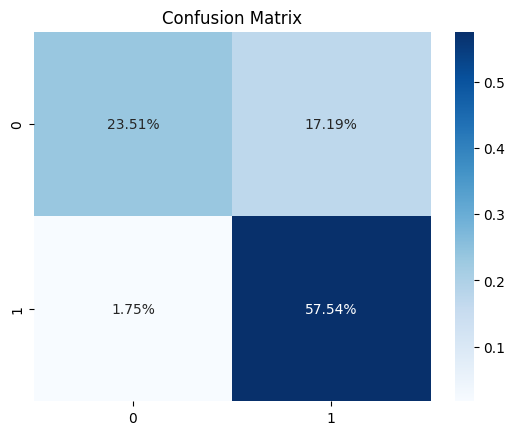

In [33]:
matrix = confusion_matrix(test_y,y_pred)
sns.heatmap(matrix/np.sum(matrix), annot=True, fmt='.2%', cmap='Blues').set(title="Confusion Matrix")
print(classification_report(test_y,y_pred))
plt.show()
print()

In [82]:
def preprocessing(news):
    # lemmatizer
    stemmer = StemmerFactory().create_stemmer()
    lemmatized_sentence = stemmer.stem(news)
    
    # sentence segmentation
    sentences = nltk.tokenize.sent_tokenize(lemmatized_sentence)
    new_words = []
    print("1")
    print(sentences)
    
    for sentence in sentences:
        # punctuations and numbers to be removed, '@' to identify mentioned user, '-' to identify sentiment word
        remove = string.punctuation.replace('-','')+'"'+'0123456789'
        # replace word, remove non ASCII, remove punctuation, remove number, remove whitespaces, to lower
        folded = sentence.replace('&amp','&').replace('&', 'dan').replace('[BENAR]','').replace('[HOAX]','').replace('(HOAX)','').replace('-',' ').replace('\n',' ').encode('ascii','ignore').decode('ascii').translate(str.maketrans('','',remove)).strip().lower()
        # word tokenizing
        words = nltk.word_tokenize(folded)
        print("2")
        print(words)
        for word in words:
            print("3")
            print(word)
            for new_word in unslang_word(word):

                    # stopword removal
                    if new_word in stopwords:
                        continue

                    # add processed word
                    new_words.append(new_word)
    processed_news = ' '.join([x for x in new_words])
    return processed_news

In [83]:
preprocessing("AADSA A")

1
['aadsa a']
2
['aadsa', 'a']
3
aadsa
3
a


'aadsa a'

In [35]:
## Ingat Benar = 0, Hoax = 1

In [47]:
tes_kalimat = 'Gempa Terkini M 3,6 Guncang Tojo Una-Una Sulteng, Berpusat di Darat'
test = tfidf_vect_8020.transform([preprocessing(tes_kalimat)])
pred = best_model.predict(test)
pred

array([0])

In [50]:
tes_kalimat = 'Pengamat: Absennya Demokrat dan Gerindra di GBK Gambarkan Peta Koalisi Terkini'
test = tfidf_vect_8020.transform([preprocessing(tes_kalimat)])
pred = best_model.predict(test)
pred

array([0])

In [46]:
tes_kalimat = 'Berita Terkini Liga 1: Aidil Sharin Sahak Mundur dari Jabatan Pelatih Persikabo 1973'
test = tfidf_vect_8020.transform([preprocessing(tes_kalimat)])
pred = best_model.predict(test)
pred

array([0])

In [53]:
tes_kalimat = 'Anies Mendapatkan Gelar Liem Ay Bon'
test = tfidf_vect_8020.transform([preprocessing(tes_kalimat)])
pred = best_model.predict(test)
pred

array([1])

In [61]:
tes_kalimat = 'Istana Hancur Total, Mahasiswa Paksa Jokowi Mundur Secara Tidak Hormat'
test = tfidf_vect_8020.transform([preprocessing(tes_kalimat)])
pred = best_model.predict(test)
pred

array([1])

In [55]:
joblib.dump(tfidf_vect_8020, 'tfidf_vectorizer.pkl')
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']